## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [1]:
N = 3500

In [2]:
### Useful routines for preparing data
import numpy as np
from numpy import array, zeros
import pandas as pd
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize

def load_imgs_and_keypoints(dirname='data/images'):
    # Write your code for loading images and points here
    imgs = []
    
    # Read csv file into pandas dataframe as convert it into numpy array
    np_gt = np.array(pd.read_csv('data//gt.csv'))
    
    # Get all pictures in cycle
    for indx, img_name in enumerate(np_gt[:N, 0]):
        # Construct path to the image and read it
        img_path = join(dirname, img_name)
        img = imread(img_path)
        
        # 2d-gray images we shout treat as 3d-arrays
        if len(img.shape) == 2:
            img = gray2rgb(img)
        
        try:
            rows, cols = img.shape[0], img.shape[1]
        except ValueError:
            print(img.shape)
        
        # Resize image to 100 x 100
        img = resize(img, (100, 100))
        imgs.append(img)
        
        # Rescale coordinates to [-0.5..0.5] range
        np_gt[indx, 1::2] = np_gt[indx, 1::2] / cols - .5
        np_gt[indx, 2::2] = np_gt[indx, 2::2] / rows - .5
        
    # Convert list of numpy images into numpy array
    imgs = np.array(imgs)
                
    return imgs, np_gt

imgs, points = load_imgs_and_keypoints()

C:\Users\Python\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [3]:
imgs.shape

(3500, 100, 100, 3)

C:\Users\Python\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


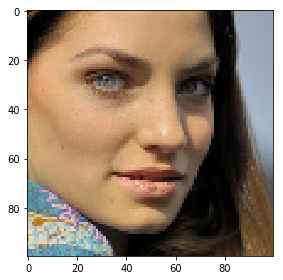

In [4]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
#points[12]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

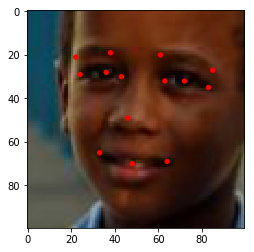

In [5]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    circles = []
    
    # Parse and transform points array
    for i in range(1, len(points)):
        if i % 2 == 1:
            x = round((points[i] + 0.5) * 100)
        else:
            y = round((points[i] + 0.5) * 100)
            circles.append(plt.Circle((x, y), 1, color='r'))
            
    fig, ax = plt.subplots()
    
    # Add circles to the image
    for circle in circles:
        ax.add_artist(circle)
    
    plt.imshow(img)
    plt.show()
    
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [6]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points[:N], test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

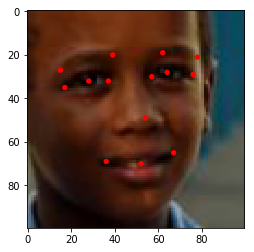

In [7]:
def flip_img(img, points):
    # Write your code for flipping here
    
    # Iterate through the points and images
    flip_img = np.flip(img, axis=1)
        
    # Flip key points
    flip_points = points.copy()
    flip_points = flip_points
    flip_points[1::2] = [-el for el in flip_points[1::2]]
    
    return flip_img, flip_points 

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [8]:
# Write your code here
aug_imgs_train = []
aug_points_train = []

for img, pts in zip(imgs_train, points_train):
    aug_img, aug_points = flip_img(img, pts)
    
    aug_imgs_train.append(aug_img)
    aug_points_train.append(aug_points)

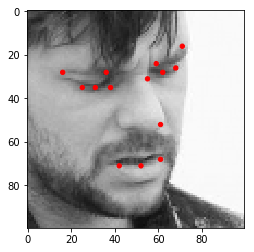

In [9]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

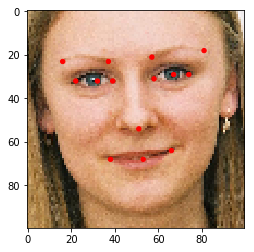

In [10]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

In [11]:
aug_imgs_train[0].shape

(100, 100, 3)

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [12]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, InputLayer
)

model = Sequential()
# Define here your model
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(28, activation='linear'))

Using TensorFlow backend.


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
__________

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [14]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

# prepare data
all_train_imgs = np.vstack((imgs_train, aug_imgs_train))
all_points_data = np.vstack((points_train, aug_points_train))
all_points_data = np.delete(all_points_data, 0, 1) # Delete first element with filename
all_points_data *= 100 # For better NN key point detecction 

# Choose optimizer, compile model and run training
adam = Adam()
model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])


model.fit(all_train_imgs, all_points_data, epochs=100);

Epoch 1/100
6300/6300 [==============================] - 67s - loss: 228.4303 - mean_squared_error: 228.4303    
Epoch 2/100
6300/6300 [==============================] - 70s - loss: 198.7467 - mean_squared_error: 198.7467    
Epoch 3/100
6300/6300 [==============================] - 63s - loss: 192.5685 - mean_squared_error: 192.5685    
Epoch 4/100
6300/6300 [==============================] - 63s - loss: 186.7106 - mean_squared_error: 186.7106    
Epoch 5/100
6300/6300 [==============================] - 53s - loss: 180.6924 - mean_squared_error: 180.6924    
Epoch 6/100
6300/6300 [==============================] - 51s - loss: 175.3310 - mean_squared_error: 175.3310    
Epoch 7/100
6300/6300 [==============================] - 54s - loss: 170.1065 - mean_squared_error: 170.1065    
Epoch 8/100
6300/6300 [==============================] - 56s - loss: 162.7145 - mean_squared_error: 162.7145    
Epoch 9/100
6300/6300 [==============================] - 50s - loss: 156.3144 - mean_squared_err

6300/6300 [==============================] - 81s - loss: 27.8043 - mean_squared_error: 27.8043    
Epoch 74/100
6300/6300 [==============================] - 83s - loss: 29.3465 - mean_squared_error: 29.3465    
Epoch 75/100
6300/6300 [==============================] - 78s - loss: 28.5218 - mean_squared_error: 28.5218    
Epoch 76/100
6300/6300 [==============================] - 79s - loss: 28.7849 - mean_squared_error: 28.7849    
Epoch 77/100
6300/6300 [==============================] - 84s - loss: 29.4627 - mean_squared_error: 29.4627    
Epoch 78/100
6300/6300 [==============================] - 84s - loss: 28.5997 - mean_squared_error: 28.5997    
Epoch 79/100
6300/6300 [==============================] - 81s - loss: 27.5671 - mean_squared_error: 27.5671    
Epoch 80/100
6300/6300 [==============================] - 75s - loss: 27.8761 - mean_squared_error: 27.8761    
Epoch 81/100
6300/6300 [==============================] - 88s - loss: 27.5809 - mean_squared_error: 27.5809    
Epoch

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [15]:
np.random.seed(42)

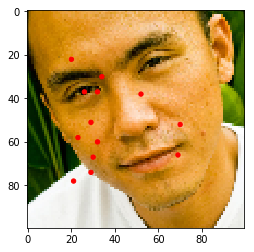

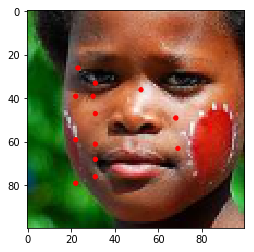

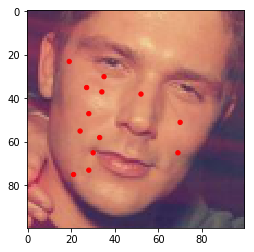

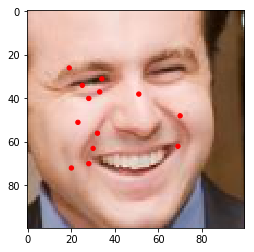

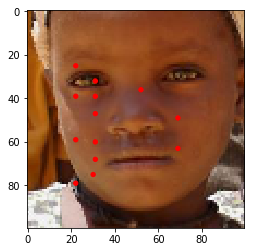

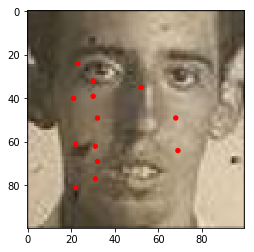

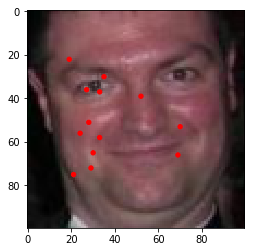

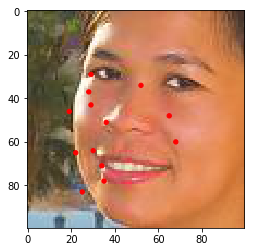

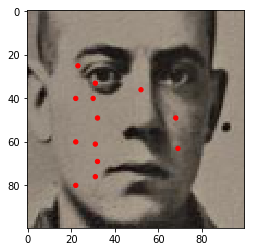

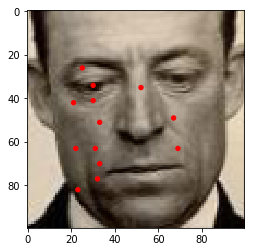

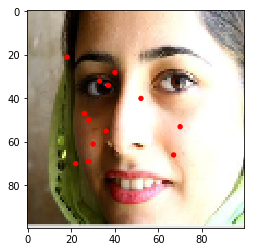

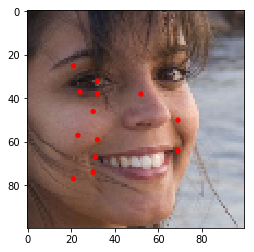

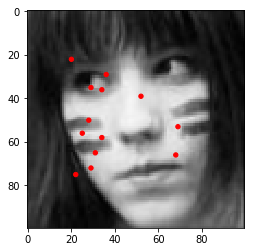

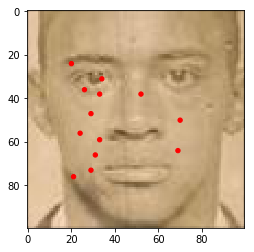

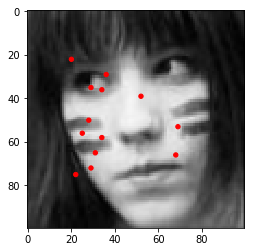

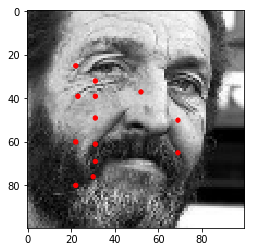

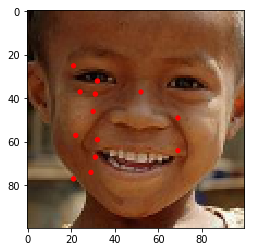

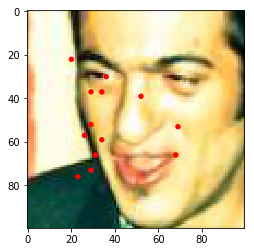

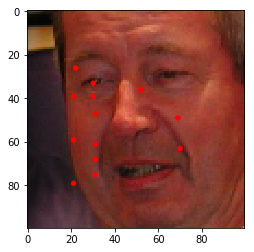

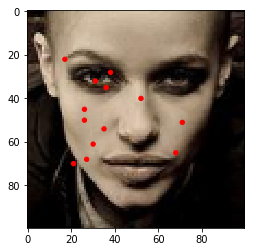

In [18]:
# Example of output
img_idxs = np.random.randint(imgs_train.shape[0], size=20)

# Predict with the aid of NN
pred_pts = model.predict(imgs_train[img_idxs])
pred_pts = pred_pts / 100

for i in range(20):
    visualize_points(imgs[img_idxs[i]], pred_pts[i])

In [ ]:
all_points_data

In [ ]:
sum(points[img_idxs][0][1:] - pred_pts[0])**2

In [ ]:
pred_pts